In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = 'cs231n/assignments/assignment1/'
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
%cd drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/cs231n/assignments/assignment1/cs231n/datasets
/content/drive/My Drive/cs231n/assignments/assignment1


# Image features exercise
*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

We have seen that we can achieve reasonable performance on an image classification task by training a linear classifier on the pixels of the input image. In this exercise we will show that we can improve our classification performance by training linear classifiers not on raw pixels but on features that are computed from the raw pixels.

All of your work for this exercise will be done in this notebook.

In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt


%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## Load data
Similar to previous exercises, we will load CIFAR-10 data from disk.

In [3]:
from cs231n.features import color_histogram_hsv, hog_feature

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    
    return X_train, y_train, X_val, y_val, X_test, y_test

X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()

## Extract Features
For each image we will compute a Histogram of Oriented
Gradients (HOG) as well as a color histogram using the hue channel in HSV
color space. We form our final feature vector for each image by concatenating
the HOG and color histogram feature vectors.

Roughly speaking, HOG should capture the texture of the image while ignoring
color information, and the color histogram represents the color of the input
image while ignoring texture. As a result, we expect that using both together
ought to work better than using either alone. Verifying this assumption would
be a good thing to try for your own interest.

The `hog_feature` and `color_histogram_hsv` functions both operate on a single
image and return a feature vector for that image. The extract_features
function takes a set of images and a list of feature functions and evaluates
each feature function on each image, storing the results in a matrix where
each column is the concatenation of all feature vectors for a single image.

In [4]:
from cs231n.features import *

num_color_bins = 10 # Number of bins in the color histogram
feature_fns = [hog_feature, lambda img: color_histogram_hsv(img, nbin=num_color_bins)]
X_train_feats = extract_features(X_train, feature_fns, verbose=True)
X_val_feats = extract_features(X_val, feature_fns)
X_test_feats = extract_features(X_test, feature_fns)

# Preprocessing: Subtract the mean feature
mean_feat = np.mean(X_train_feats, axis=0, keepdims=True)
X_train_feats -= mean_feat
X_val_feats -= mean_feat
X_test_feats -= mean_feat

# Preprocessing: Divide by standard deviation. This ensures that each feature
# has roughly the same scale.
std_feat = np.std(X_train_feats, axis=0, keepdims=True)
X_train_feats /= std_feat
X_val_feats /= std_feat
X_test_feats /= std_feat

# Preprocessing: Add a bias dimension
X_train_feats = np.hstack([X_train_feats, np.ones((X_train_feats.shape[0], 1))])
X_val_feats = np.hstack([X_val_feats, np.ones((X_val_feats.shape[0], 1))])
X_test_feats = np.hstack([X_test_feats, np.ones((X_test_feats.shape[0], 1))])

Done extracting features for 1000 / 49000 images
Done extracting features for 2000 / 49000 images
Done extracting features for 3000 / 49000 images
Done extracting features for 4000 / 49000 images
Done extracting features for 5000 / 49000 images
Done extracting features for 6000 / 49000 images
Done extracting features for 7000 / 49000 images
Done extracting features for 8000 / 49000 images
Done extracting features for 9000 / 49000 images
Done extracting features for 10000 / 49000 images
Done extracting features for 11000 / 49000 images
Done extracting features for 12000 / 49000 images
Done extracting features for 13000 / 49000 images
Done extracting features for 14000 / 49000 images
Done extracting features for 15000 / 49000 images
Done extracting features for 16000 / 49000 images
Done extracting features for 17000 / 49000 images
Done extracting features for 18000 / 49000 images
Done extracting features for 19000 / 49000 images
Done extracting features for 20000 / 49000 images
Done extr

## Train SVM on features
Using the multiclass SVM code developed earlier in the assignment, train SVMs on top of the features extracted above; this should achieve better results than training SVMs directly on top of raw pixels.

In [5]:
# Use the validation set to tune the learning rate and regularization strength

from cs231n.classifiers.linear_classifier import LinearSVM

learning_rates = [8.5e-9, 9e-9, 9.5e-9, 1e-8]
regularization_strengths = [3.5e5, 4e5, 4.5e5, 5e5, 5.5e5]

results = {}
best_val = -1
best_svm = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained classifer in best_svm. You might also want to play          #
# with different numbers of bins in the color histogram. If you are careful    #
# you should be able to get accuracy of near 0.44 on the validation set.       #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
for l in learning_rates:
    for r in regularization_strengths:
        svm = LinearSVM()
        svm.train(X_train_feats, y_train, l, r,
                      num_iters=1500, verbose=True)
        train_ac = np.mean(y_train == svm.predict(X_train_feats))
        val_ac = np.mean(y_val == svm.predict(X_val_feats))
        if val_ac > best_val:
          best_val, best_svm = val_ac, svm
        results[(l,r)] = (train_ac ,val_ac)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved: %f' % best_val)

iteration 0 / 1500: loss 542.738659
iteration 100 / 1500: loss 170.800441
iteration 200 / 1500: loss 58.048285
iteration 300 / 1500: loss 23.865857
iteration 400 / 1500: loss 13.507107
iteration 500 / 1500: loss 10.365869
iteration 600 / 1500: loss 9.413846
iteration 700 / 1500: loss 9.125645
iteration 800 / 1500: loss 9.037969
iteration 900 / 1500: loss 9.011479
iteration 1000 / 1500: loss 9.003448
iteration 1100 / 1500: loss 9.001002
iteration 1200 / 1500: loss 9.000270
iteration 1300 / 1500: loss 9.000060
iteration 1400 / 1500: loss 8.999969
iteration 0 / 1500: loss 635.722110
iteration 100 / 1500: loss 169.109113
iteration 200 / 1500: loss 49.906112
iteration 300 / 1500: loss 19.449341
iteration 400 / 1500: loss 11.668146
iteration 500 / 1500: loss 9.682428
iteration 600 / 1500: loss 9.174142
iteration 700 / 1500: loss 9.044477
iteration 800 / 1500: loss 9.011369
iteration 900 / 1500: loss 9.002814
iteration 1000 / 1500: loss 9.000697
iteration 1100 / 1500: loss 9.000148
iteration 

In [6]:
# Evaluate your trained SVM on the test set: you should be able to get at least 0.40
y_test_pred = best_svm.predict(X_test_feats)
test_accuracy = np.mean(y_test == y_test_pred)
print(test_accuracy)

0.412


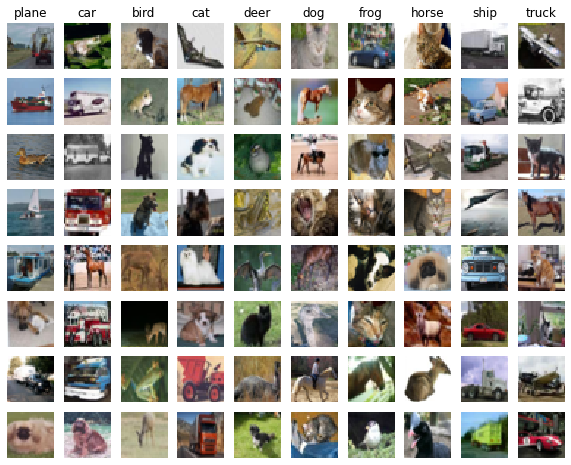

In [7]:
# An important way to gain intuition about how an algorithm works is to
# visualize the mistakes that it makes. In this visualization, we show examples
# of images that are misclassified by our current system. The first column
# shows images that our system labeled as "plane" but whose true label is
# something other than "plane".

examples_per_class = 8
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for cls, cls_name in enumerate(classes):
    idxs = np.where((y_test != cls) & (y_test_pred == cls))[0]
    idxs = np.random.choice(idxs, examples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt.subplot(examples_per_class, len(classes), i * len(classes) + cls + 1)
        plt.imshow(X_test[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls_name)
plt.show()

### Inline question 1:
Describe the misclassification results that you see. Do they make sense?


$\color{blue}{\textit Your Answer:}$

I think no. As the most highest accuracy is lower than 0.5, so we can predict there are many misclassifications.

In more details for the plane class, the images with bright background could get highsocres. In truck cases, there are less animal images but there are still some animals.

Generally, our classifier mostly could decide whether the image is veichle or animal. But it couldn't classify well into detail classes. And we could see the images with similar background tone were classified in ths same class.


## Neural Network on image features
Earlier in this assigment we saw that training a two-layer neural network on raw pixels achieved better classification performance than linear classifiers on raw pixels. In this notebook we have seen that linear classifiers on image features outperform linear classifiers on raw pixels. 

For completeness, we should also try training a neural network on image features. This approach should outperform all previous approaches: you should easily be able to achieve over 55% classification accuracy on the test set; our best model achieves about 60% classification accuracy.

In [8]:
# Preprocessing: Remove the bias dimension
# Make sure to run this cell only ONCE
print(X_train_feats.shape)
X_train_feats = X_train_feats[:, :-1]
X_val_feats = X_val_feats[:, :-1]
X_test_feats = X_test_feats[:, :-1]

print(X_train_feats.shape)

(49000, 155)
(49000, 154)


In [22]:
from cs231n.classifiers.fc_net import TwoLayerNet
from cs231n.solver import Solver

input_dim = X_train_feats.shape[1]
hidden_dim = 500
num_classes = 10

net = TwoLayerNet(input_dim, hidden_dim, num_classes)
best_net = None

################################################################################
# TODO: Train a two-layer neural network on image features. You may want to    #
# cross-validate various parameters as in previous sections. Store your best   #
# model in the best_net variable.                                              #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
data = {
      'X_train': X_train_feats,
      'y_train': y_train,
      'X_val': X_val_feats,
      'y_val': y_val,
      'X_test' : X_test_feats,
      'y_test' : y_test
    }
best_acc = 0
results = {}
learning_rates = [5e-2,7.5e-2]
regularizations = [7.5e-4]
hidden_dims = [1000]
lr_decays = [0.95,1]

for h in hidden_dims:
  for l in learning_rates:
      for r in regularizations:
        for d in lr_decays:
          net = TwoLayerNet(input_dim, hidden_dim, num_classes, reg=r)
          solver = Solver(net, data,
                      update_rule='sgd',
                      optim_config={
                        'learning_rate': l,
                      },
                      lr_decay=d,
                      num_epochs=15, batch_size=100,
                      print_every = 100
                      )
          solver.train()
          val_acc = solver.val_acc_history[-1]
          train_acc = solver.train_acc_history[-1]
          if val_acc > best_acc:
              best_acc  = val_acc
              best_net = net
          results[(h,l,r,d)] = (train_acc,val_acc)

for hid, lr, reg, dec in sorted(results):
    train_acc, val_acc = results[(hid,lr,reg,dec)]
    print('hid %d lr %e reg %e dec %f -> train accuracy: %f val accuracy: %f' % (
                hid, lr,reg, dec, train_acc, val_acc))
print('best validation accuracy achieved during cross-validation: %f' % best_acc)
# We could get the highest accuracy when hid 1000 lr 7.5e-02 reg 7.5e-04 dec 0.95
# train accuracy: 0.685000 val accuracy: 0.606000
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****


(Iteration 1 / 7350) loss: 2.302637
(Epoch 0 / 15) train acc: 0.091000; val_acc: 0.113000
(Iteration 101 / 7350) loss: 2.298792
(Iteration 201 / 7350) loss: 2.225908
(Iteration 301 / 7350) loss: 1.977015
(Iteration 401 / 7350) loss: 1.886540
(Epoch 1 / 15) train acc: 0.413000; val_acc: 0.385000
(Iteration 501 / 7350) loss: 1.619968
(Iteration 601 / 7350) loss: 1.559841
(Iteration 701 / 7350) loss: 1.549589
(Iteration 801 / 7350) loss: 1.435941
(Iteration 901 / 7350) loss: 1.469190
(Epoch 2 / 15) train acc: 0.466000; val_acc: 0.492000
(Iteration 1001 / 7350) loss: 1.498903
(Iteration 1101 / 7350) loss: 1.365768
(Iteration 1201 / 7350) loss: 1.490767
(Iteration 1301 / 7350) loss: 1.329678
(Iteration 1401 / 7350) loss: 1.343050
(Epoch 3 / 15) train acc: 0.524000; val_acc: 0.516000
(Iteration 1501 / 7350) loss: 1.488644
(Iteration 1601 / 7350) loss: 1.306923
(Iteration 1701 / 7350) loss: 1.382592
(Iteration 1801 / 7350) loss: 1.180373
(Iteration 1901 / 7350) loss: 1.341741
(Epoch 4 / 15) t

In [23]:
# Run your best neural net classifier on the test set. You should be able
# to get more than 55% accuracy.

y_test_pred = np.argmax(best_net.loss(data['X_test']), axis=1)
test_acc = (y_test_pred == data['y_test']).mean()
print(test_acc)

0.576
